In [3]:
!pip install numpy
!pip install graphviz

                                              0.0/14.8 MB ? eta -:--:--
                                             0.0/14.8 MB 660.6 kB/s eta 0:00:23
                                              0.2/14.8 MB 2.4 MB/s eta 0:00:07
     -                                        0.7/14.8 MB 5.2 MB/s eta 0:00:03
     ---                                      1.3/14.8 MB 7.7 MB/s eta 0:00:02
     -----                                    1.9/14.8 MB 8.7 MB/s eta 0:00:02
     ------                                   2.5/14.8 MB 9.5 MB/s eta 0:00:02
     -------                                  2.9/14.8 MB 9.4 MB/s eta 0:00:02
     ---------                                3.5/14.8 MB 9.7 MB/s eta 0:00:02
     ----------                               4.1/14.8 MB 10.0 MB/s eta 0:00:02
     ------------                             4.8/14.8 MB 10.5 MB/s eta 0:00:01
     --------------                           5.4/14.8 MB 10.7 MB/s eta 0:00:01
     ----------------                         6.0/14.8 

In [1]:
import numpy as np
import math

In [31]:
class Value:
    def __init__(self, data, _children=(), _op='', label='') :
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
        self.grad = 0
        
    def __repr__(self) :
        return f"Value(data={self.data})"
    
    def __add__(self, other) :
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other) : 
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1)/(math.exp(2*x) +1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
               self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
    
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
          node._backward()

In [22]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b') 
c = Value(10.0, label='c')
d = a*b + c; d.label ='d'
f = Value(-2.0, label ='f')
L = d*f; L.label = 'L'
print(L)

Value(data=-8.0)


In [23]:
print(d._prev)
print(d._op)

{Value(data=-6.0), Value(data=10.0)}
+


In [24]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

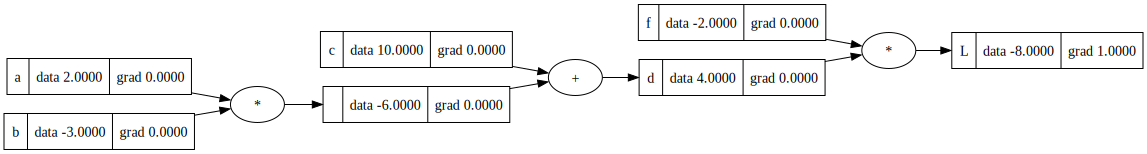

In [25]:
L.grad = 1.0

draw_dot(L)

## Backpropagate through a neuron

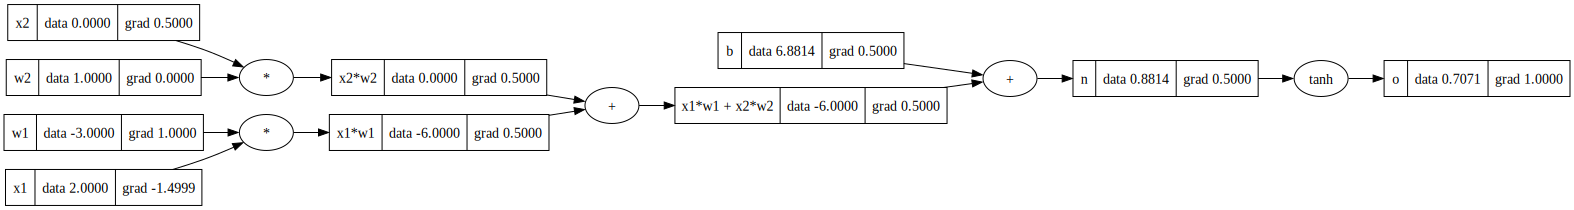

In [36]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1, w2
w1 = Value(-3.0, label ='w1')
w2 = Value(1.0, label='w2')
#Bias b
b = Value(6.8814,label='b')
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2" 
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label='o'

o.backward()


draw_dot(o)

In [34]:
# o =tanh(n)
# do/dn = 1 - (tanh(n))²= 1 - o² 
 